In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import joblib
import keras_tuner as kt
import tensorflow.keras.utils as kutils
from tqdm import tqdm

In [2]:
game_window = 4

# Big Dataset

In [3]:
final_df = None

data = pd.read_csv(f"sports-miner.fbref.2.csv")

data['date'] = pd.to_datetime(data['date'], dayfirst=True, unit="ms")

home_stats = data[["home_team","away_team","date","stats.possesion_home", "stats.passes_home", "stats.passes_completed_home", "stats.passes_away",
                   'stats.passes_completed_away','stats.fouls_home','stats.corners_home',"stats.score_home","stats.score_away",
                   "stats.cards_yellow_home","stats.cards_red_home","stats.shots_home", "stats.shots_away","stats.shots_on_target_home",
                   "stats.shots_on_target_away","season","league", "odds.B365H", "odds.B365D", "odds.B365A"]].copy()
home_stats.rename(columns={
        'home_team': 'team',
        'away_team': 'opponent',
        'stats.score_home': 'goals_for',
        'stats.score_away': 'goals_against',
        'stats.shots_home': 'shots',
        'stats.shots_away': 'shots_against',
        'stats.shots_on_target_home': 'shots_on_target',
        'stats.shots_on_target_away': 'shots_on_target_against',
        'stats.possesion_home': 'possesion',
        "stats.passes_home": "passes",
        "stats.passes_completed_home": "passes_completed",
        "stats.passes_away": "passes_against",
        "stats.passes_completed_away": "passes_completed_against",
        'stats.corners_home': 'corners',
        'stats.fouls_home': 'fouls',
        'stats.cards_yellow_home': 'yellow_cards',
        'stats.cards_red_home': 'red_cards'
    }, inplace=True)
home_stats['home_away'] = 1
home_stats['diff'] = home_stats['goals_for'] - home_stats['goals_against']
home_stats['result'] = home_stats['diff'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

away_stats = data[["home_team","away_team","date","stats.possesion_away", "stats.passes_home", "stats.passes_completed_home", "stats.passes_away",
                   'stats.passes_completed_away','stats.fouls_away','stats.corners_away',"stats.score_home","stats.score_away",
                   "stats.cards_yellow_away","stats.cards_red_away","stats.shots_home", "stats.shots_away","stats.shots_on_target_home",
                   "stats.shots_on_target_away","season","league", "odds.B365H", "odds.B365D", "odds.B365A"]].copy()
away_stats.rename(columns={
        'home_team': 'opponent',
        'away_team': 'team',
        'stats.score_home': 'goals_against',
        'stats.score_away': 'goals_for',
        'stats.shots_away': 'shots',
        'stats.shots_home': 'shots_against',
        'stats.shots_on_target_away': 'shots_on_target',
        'stats.shots_on_target_home': 'shots_on_target_against',
        'stats.possesion_away': 'possesion',
        "stats.passes_away": "passes",
        "stats.passes_completed_away": "passes_completed",
        "stats.passes_home": "passes_against",
        "stats.passes_completed_home": "passes_completed_against",
        'stats.corners_away': 'corners',
        'stats.fouls_away': 'fouls',
        'stats.cards_yellow_away': 'yellow_cards',
        'stats.cards_red_away': 'red_cards'
    }, inplace=True)
away_stats['home_away'] = 0
away_stats['diff'] = away_stats['goals_for'] - away_stats['goals_against']
away_stats['result'] = away_stats['diff'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)

team_stats.dropna() # check this
team_stats.sort_values(by='date', inplace=True)

aggregate_features = ['goals_for', 'goals_against', 'shots', 'shots_on_target', 'possesion', 'passes', 'passes_completed', 'result', 'shots_on_target_against', "passes_against", "passes_completed_against" ]

processed_seasons = []

def compute_rolling_results(grp, window):
    grp = grp.sort_values(by='date')
    # Shift the values so that the current game is not included
    shifted_home = grp['home_away'].shift()
    shifted_diff = grp['diff'].shift()
    
    # Compute wins using the custom conditions:
    # For home games (home_away == 1): win if diff > 0
    # For away games (home_away == 0): win if diff > 0
    wins = (((shifted_home == 1) & (shifted_diff > 0)) |
            ((shifted_home == 0) & (shifted_diff > 0))).astype(int)
    
    # Draws: when diff == 0 (for both home and away)
    draws = (shifted_diff == 0).astype(int)
    
    # Losses:
    # For home games: loss if diff < 0
    # For away games: loss if diff < 0
    losses = (((shifted_home == 1) & (shifted_diff < 0)) |
              ((shifted_home == 0) & (shifted_diff < 0))).astype(int)
    
    grp['past_games_wins'] = wins.rolling(window=window, min_periods=1).sum()
    grp['past_games_draws'] = draws.rolling(window=window, min_periods=1).sum()
    grp['past_games_losses'] = losses.rolling(window=window, min_periods=1).sum()
    
    return grp

for season in team_stats['season'].unique():
    season_data = team_stats[team_stats['season'] == season].copy()
    
    # Apply rolling calculation for each feature
    for feature in aggregate_features:
        season_data[feature] = (
            season_data.groupby('team')[feature]
            .transform(lambda x: x.shift().rolling(window=game_window, min_periods=game_window).mean())
        )
    season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_results(grp, game_window))
    
    processed_seasons.append(season_data)

team_stats = pd.concat(processed_seasons, ignore_index=True)

team_stats = team_stats.dropna()
df = team_stats

home_df = df[df['home_away'] == 1].copy()
away_df = df[df['home_away'] == 0].copy()

home_df = home_df.rename(lambda x: x + '_home' if x not in ['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"] else x, axis=1)
away_df = away_df.rename(lambda x: x + '_away' if x not in ['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"] else x, axis=1)
final_df = pd.merge(
        home_df,
        away_df,
        left_on=['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"],
        right_on=['season', 'league', 'date', 'opponent', 'team', "odds.B365H", "odds.B365D", "odds.B365A"],
        suffixes=('_home', '_away')
)
final_df['target'] = final_df['diff_home'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))
final_df.sort_values('date', inplace=True)

C:\Users\ghera\AppData\Local\Temp\ipykernel_26136\1351870124.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_results(grp, game_window))
C:\Users\ghera\AppData\Local\Temp\ipykernel_26136\1351870124.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_r

In [4]:
# Passes rates
final_df['passes_rate_home'] = np.where(
   final_df["passes_home"] == 0, 
   0, 
   final_df["passes_completed_home"] / final_df["passes_home"]
)
final_df['passes_rate_away'] = np.where(
   final_df["passes_away"] == 0, 
   0, 
   final_df["passes_completed_away"] / final_df["passes_away"]
)
final_df['passes_rate_against_home'] = np.where(
   final_df["passes_against_home"] == 0, 
   0, 
   final_df["passes_completed_against_home"] / final_df["passes_against_home"]
)
final_df['passes_rate_against_away'] = np.where(
   final_df["passes_against_away"] == 0, 
   0, 
   final_df["passes_completed_against_away"] / final_df["passes_against_away"]
)

# Shots rates
final_df['shots_rate_home'] = np.where(
   final_df["shots_home"] == 0, 
   0, 
   final_df["shots_on_target_home"] / final_df["shots_home"]
)
final_df['shots_rate_away'] = np.where(
   final_df["shots_away"] == 0, 
   0, 
   final_df["shots_on_target_away"] / final_df["shots_away"]
)
final_df['shots_rate_against_home'] = np.where(
   final_df["shots_against_home"] == 0, 
   0, 
   final_df["shots_on_target_against_home"] / final_df["shots_against_home"]
)
final_df['shots_rate_against_away'] = np.where(
   final_df["shots_against_away"] == 0, 
   0, 
   final_df["shots_on_target_against_away"] / final_df["shots_against_away"]
)

final_df['cards_home'] = final_df['yellow_cards_home'] + 3 * final_df["red_cards_home"]
final_df['cards_away'] = final_df['yellow_cards_away'] + 3 * final_df["red_cards_away"]

In [10]:
feature_columns = ['goals_for_home', 'goals_against_home',
                           'shots_home', 'shots_on_target_home',
                           'shots_against_home' ,'shots_on_target_against_home',
                           # "shots_rate_home", "shots_rate_against_home",
                           # 'passes_home', 
                           # "passes_against_home",
                           'passes_completed_home',
                           "passes_completed_against_home",
                           # "passes_rate_home", "passes_rate_against_home",
                           'possesion_home',
                           # 'corners_home', 'fouls_home',
                           # "cards_home",
                           "past_games_losses_home", "past_games_draws_home", "past_games_wins_home",
                           # 'result_home',
                           'goals_for_away', 'goals_against_away',
                           'shots_away', 'shots_on_target_away',
                           'shots_against_away', 'shots_on_target_against_away', 
                           # "shots_rate_away", "shots_rate_against_away",
                           # 'passes_away',
                           # "passes_against_away",
                           'passes_completed_away',
                           "passes_completed_against_away", 
                           # "passes_rate_away", "passes_rate_against_away",
                           'possesion_away',
                           # 'corners_away', 'fouls_away',
                           # "cards_away",
                           "past_games_losses_away", "past_games_draws_away", "past_games_wins_away"
                           # 'result_away'
                  ]
# feature_columns.extend(['yellow_cards_home', 'red_cards_home', 'yellow_cards_away', 'red_cards_away'])

scaler = MinMaxScaler()
scaler.fit(final_df[feature_columns])
to_split = final_df[feature_columns]
to_split = scaler_new.transform(final_df[feature_columns])

X_train, X_test, y_train, y_test = train_test_split(to_split, final_df[[ "odds.B365H", "odds.B365D", "odds.B365A", 'target']], test_size=0.10, random_state=42)

print(X_train.shape)
print(X_test.shape)
print("A: " + str(len(final_df.loc[final_df['target'] == 0])))
print("D: " + str(len(final_df.loc[final_df['target'] == 1])))
print("H: " + str(len(final_df.loc[final_df['target'] == 2])))

(16877, 24)
(1876, 24)
A: 5763
D: 4622
H: 8368


In [11]:
final_df[["team_home", "opponent_home", "date", "possesion_home", "possesion_away",
          "past_games_wins_home", "past_games_draws_home", "past_games_losses_home",
         "past_games_wins_away", "past_games_draws_away", "past_games_losses_away",
         "target"]].head()

,team_home,opponent_home,date,possesion_home,possesion_away,past_games_wins_home,past_games_draws_home,past_games_losses_home,past_games_wins_away,past_games_draws_away,past_games_losses_away,target
187,Newcastle United,Hull City,2014-09-19 21:00:00,54.50,47.00,0.0,2.0,2.0,1.0,2.0,1.0,1
34,Burnley,Sunderland,2014-09-19 21:00:00,43.75,46.25,0.0,2.0,2.0,0.0,3.0,1.0,1
204,Queens Park Rangers,Stoke City,2014-09-19 21:00:00,39.50,51.75,1.0,0.0,3.0,1.0,1.0,2.0,1
17,Aston Villa,Arsenal,2014-09-19 21:00:00,36.75,60.75,3.0,1.0,0.0,1.0,3.0,0.0,0
323,West Ham United,Liverpool,2014-09-19 21:00:00,49.00,54.50,1.0,1.0,2.0,2.0,0.0,2.0,2


# Validation dataset

## Constants

In [12]:
from pymongo import MongoClient
import time
import datetime
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
import numpy as np

mongoClient = MongoClient("mongodb+srv://u:p@cluster.ywrlr.mongodb.net/score-lab?retryWrites=true&w=majority&appName=Cluster", connectTimeoutMS=300000)
collectionPredictions = mongoClient["score-lab"]["predictions"]
mongoClientLocal = MongoClient("mongodb://localhost:27017/")
collectionData = mongoClientLocal["sports-miner"]["fbref"]

TEAM_MAPPINGS = {
    "Borussia Dortmund": "Dortmund",
    "SC Freiburg": "Freiburg",
    "VfL Wolfsburg": "Wolfsburg",
    "VfL Bochum": "Bochum",
    "FSV Mainz 05": "Mainz 05",
    "FC St. Pauli": "St. Pauli",
    "Borussia Mönchengladbach": "Mönchengladbach",
    "FC Koln": "Köln",
    "FC Augsburg": "Augsburg",
    "1. FC Heidenheim": "Heidenheim",
    "Bayern München": "Bayern Munich",
    "1899 Hoffenheim": "Hoffenheim",
    "VfB Stuttgart": "Stuttgart",
    "VfL Wolfsburg": "Wolfsburg",
    "Alaves": "Alavés",
    "Atletico Madrid": "Atlético Madrid",
    "Leganes": "Leganés",
    "AC Milan": "Milan",
    "Inter": "Internazionale",
    "Verona": "Hellas Verona",
    "AS Roma": "Roma",
    "Saint Etienne": "Saint-Étienne",
    "LE Havre": "Le Havre",
    "Stade Brestois 29": "Brest",
    "Paris Saint Germain": "Paris Saint-Germain",
    "Leicester": "Leicester City",
    "Newcastle": "Newcastle United",
    "Brighton": "Brighton & Hove Albion",
    "Wolves": "Wolverhampton Wanderers",
    "West Ham": "West Ham United",
    "Ipswich": "Ipswich Town",
    "Tottenham": "Tottenham Hotspur",
    "Almere City FC": "Almere City",
    "Waalwijk": "RKC Waalwijk",
    "Heracles": "Heracles Almelo",
    "GO Ahead Eagles": "Go Ahead Eagles",
    "PEC Zwolle": "Zwolle",
    "SC Braga": "Braga",
    "GIL Vicente": "Gil Vicente FC",
    "AVS": "AVS Futebol",
    "Famalicao": "Famalicão",
    "FC Porto": "Porto",
    "Guimaraes": "Vitória Guimarães"
};

# feature_columns = ['goals_for_home', 'goals_against_home',
#                            'shots_home', 'shots_on_target_home',
#                            'shots_against_home' ,'shots_on_target_against_home',
#                            # "shots_rate_home", "shots_rate_against_home",
#                            # 'passes_home', 
#                            # "passes_against_home",
#                            'passes_completed_home',
#                            "passes_completed_against_home",
#                            # "passes_rate_home", "passes_rate_against_home",
#                            'possesion_home',
#                            # 'corners_home', 'fouls_home',
#                            # "cards_home",
#                            "past_games_losses_home", "past_games_draws_home", "past_games_wins_home",
#                            # 'result_home',
#                            'goals_for_away', 'goals_against_away',
#                            'shots_away', 'shots_on_target_away',
#                            'shots_against_away', 'shots_on_target_against_away', 
#                            # "shots_rate_away", "shots_rate_against_away",
#                            # 'passes_away',
#                            # "passes_against_away",
#                            'passes_completed_away',
#                            "passes_completed_against_away", 
#                            # "passes_rate_away", "passes_rate_against_away",
#                            'possesion_away',
#                            # 'corners_away', 'fouls_away',
#                            # "cards_away",
#                            "past_games_losses_away", "past_games_draws_away", "past_games_wins_away"
#                            # 'result_away'
#                   ]

def notGameType(gameType):
    if gameType == "_home":
        return "_away"
    return "_home"

TIMESTAMP_LIMIT = 100 * 24 * 60 * 60 * 1000 # 40 days
step = 0
final_df_validation = pd.DataFrame()
logging = False

## Create dataset

In [14]:
predictions = collectionPredictions.find({"league.id": {"$nin": [2,3]} }).sort({"date": -1}).to_list() # The query should be something related to current date/ season etc. This is a first itteration for now every time
for prediction in tqdm(predictions):
    fixture = prediction["fixture"]
    timestamp = int(time.mktime(datetime.datetime.strptime(prediction["date"],
                                            "%Y-%m-%d").timetuple())) * 1000
    home_team_query = prediction['teams']['home']['name']
    away_team_query = prediction['teams']['away']['name']

    if (TEAM_MAPPINGS.get(prediction['teams']['home']['name'])):
        home_team_query = TEAM_MAPPINGS[prediction['teams']['home']['name']]
    if (TEAM_MAPPINGS.get(prediction['teams']['away']['name'])):
        away_team_query = TEAM_MAPPINGS[prediction['teams']['away']['name']]

    home_team = collectionData.find({"$or": [{"home_team": home_team_query}, {"away_team": home_team_query}], "date": { "$lt": timestamp, "$gt": timestamp - TIMESTAMP_LIMIT}}).sort("date", -1).limit(game_window).to_list()
    away_team = collectionData.find({"$or": [{"home_team": away_team_query}, {"away_team": away_team_query}], "date": { "$lt": timestamp, "$gt": timestamp - TIMESTAMP_LIMIT}}).sort("date", -1).limit(game_window).to_list()

    if len(home_team) < game_window or len(away_team) < game_window:
        # print("Not enough data for ", home_team_query, away_team_query)
        if (len(home_team) == 0 or len(away_team) == 0) and logging:
            print("Not enough data for ", home_team_query, away_team_query)
            print("CAUTION!!! Home team: ", len(home_team), " Away team: ", len(away_team))
        continue

    stats_to_consider = [
        "shots",
        "shots_on_target",
        "passes_completed",
        "possesion",
    ]

    stats_to_consider_against = [
        "shots_on_target",
        "shots",
        "passes_completed",
    ]

    home_team_stats = {}
    wins = 0
    draws = 0
    losses = 0
    for game in home_team:
        try:
            game_type = "_home"
            if game["home_team"] != home_team_query:
                game_type = "_away"

            if game["stats"]["score" + game_type] > game["stats"]["score" + notGameType(game_type)]:
                wins += 1
            elif game["stats"]["score" + game_type] == game["stats"]["score" + notGameType(game_type)]:
                draws += 1
            else:
                losses += 1
            
            if home_team_stats.get("goals_for" + "_home", None) == None:
                home_team_stats["goals_for" + "_home"] = 0
            if home_team_stats.get("goals_against" + "_home", None) == None:
                home_team_stats["goals_against" + "_home"] = 0

            home_team_stats["goals_for" + "_home"] += game["stats"]["score" + game_type]
            home_team_stats["goals_against" + "_home"] += game["stats"]["score" + notGameType(game_type)]

            for feature in stats_to_consider:
                currentFeature = feature + game_type
                if home_team_stats.get(feature + "_home", None) != None:
                    home_team_stats[feature + "_home"] += game["stats"].get(currentFeature)
                else:
                    home_team_stats[feature + "_home"] = game["stats"].get(currentFeature)
                
            for feature in stats_to_consider_against:
                currentFeature = feature + notGameType(game_type)
                if home_team_stats.get(feature + "_against_home", None) != None:
                    home_team_stats[feature + "_against_home"] += game["stats"].get(currentFeature)
                else:
                    home_team_stats[feature + "_against_home"] = game["stats"].get(currentFeature)
        except Exception as e:
            if logging:
                print(game)

    home_team_stats["past_games_wins_home"] = wins
    home_team_stats["past_games_draws_home"] = draws
    home_team_stats["past_games_losses_home"] = losses

    away_team_stats = {}
    wins = 0
    draws = 0
    losses = 0
    for game in away_team:
        try:
            game_type = "_home"
            if game["home_team"] != away_team_query:
                game_type = "_away"

            if game["stats"]["score" + game_type] > game["stats"]["score" + notGameType(game_type)]:
                wins += 1
            elif game["stats"]["score" + game_type] == game["stats"]["score" + notGameType(game_type)]:
                draws += 1
            else:
                losses += 1
            
            if away_team_stats.get("goals_for" + "_away", None) == None:
                away_team_stats["goals_for" + "_away"] = 0
            if away_team_stats.get("goals_against" + "_away", None) == None:
                away_team_stats["goals_against" + "_away"] = 0

            away_team_stats["goals_for" + "_away"] += game["stats"]["score" + game_type]
            away_team_stats["goals_against" + "_away"] += game["stats"]["score" + notGameType(game_type)]

            for feature in stats_to_consider:
                currentFeature = feature + game_type
                if away_team_stats.get(feature + "_away", None) != None:
                    away_team_stats[feature + "_away"] += game["stats"].get(currentFeature)
                else:
                    away_team_stats[feature + "_away"] = game["stats"].get(currentFeature)
                
            for feature in stats_to_consider_against:
                currentFeature = feature + notGameType(game_type)
                if away_team_stats.get(feature + "_against_away", None) != None:
                    away_team_stats[feature + "_against_away"] += game["stats"].get(currentFeature)
                else:
                    away_team_stats[feature + "_against_away"] = game["stats"].get(currentFeature)
        except Exception as e:
            if logging:
                print(game)
    
    away_team_stats["past_games_wins_away"] = wins
    away_team_stats["past_games_draws_away"] = draws
    away_team_stats["past_games_losses_away"] = losses

    for key, value in home_team_stats.items():
        if not key.startswith("past_games"):
            home_team_stats[key] = value / 4
    for key, value in away_team_stats.items():
        if not key.startswith("past_games"):
            away_team_stats[key] = value / 4

    df1 = pd.DataFrame([home_team_stats])
    df2 = pd.DataFrame([away_team_stats])
    df = pd.concat([df1, df2], axis=1)
    current_game = collectionData.find_one({"home_team": home_team_query, "away_team": away_team_query, "season": "2024-2025"})

    if current_game == None: # TODO: This is big problem
        if logging:
            print(home_team_query, away_team_query)
            print(prediction.get("fixture").get("id"))
        continue

    result = None
    if current_game.get("odds", None) == None:
        if logging:
            print(home_team_query, away_team_query)
            print(prediction.get("fixture").get("id"))
        continue

    result = current_game["stats"]["score_home"] - current_game["stats"]["score_away"]
    if result > 0:
        result = 2
    elif result < 0:
        result = 0
    else:
        result = 1
    
    extraInfo = pd.DataFrame([{
        "target": result,
        "odds.B365A": current_game['odds']['B365A'],
        "odds.B365D": current_game['odds']['B365D'],
        "odds.B365H": current_game['odds']['B365H']
    }])
    df = pd.concat([df, extraInfo], axis=1)
    final_df_validation = pd.concat([final_df_validation, df], axis=0)

100%|██████████████████████████████████████████████████████████████████████| 2372/2372 [01:29<00:00, 26.37it/s]


## Format

In [15]:
scaler_new = joblib.load("D:\\Repos\\Personal\\score-lab-ai\\checkpoints\\saved_scaler_model_nr_18_clasic.pkl")

In [16]:
X_test_validation = scaler_new.transform(final_df_validation[feature_columns])
y_test_validation = final_df_validation[[ "odds.B365H", "odds.B365D", "odds.B365A", 'target']]

# REST

## Basic model

In [21]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(final_df['target']),
                                     y=final_df['target'])

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Computed class_weight_dict:", class_weight_dict)

rf_model = RandomForestClassifier(
    n_estimators=250,          # Increase number of trees
    max_depth=20,              # Slightly deeper trees
    min_samples_split=10,       # More flexible splitting
    min_samples_leaf=10,        # More flexible leaves
    max_features='sqrt',       # Common choice to reduce correlation
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=10
)

hgb_model = HistGradientBoostingClassifier(
    max_iter=400,               # More boosting iterations
    max_depth=15,               # Reasonably deep
    learning_rate=0.03,         # Slightly smaller LR
    # min_samples_leaf=5,         # Controls overfitting
    # l2_regularization=1.0,      # Regularization to reduce overfit
    early_stopping=True,
    scoring='balanced_accuracy',# Makes sense in imbalanced data
    random_state=10
)

cat_model = CatBoostClassifier(
    iterations=500,            # More iterations
    # depth=8,                   # Controls model complexity
    learning_rate=0.03,        # Slightly smaller LR
    # l2_leaf_reg=3,             # L2 regularization
    # border_count=128,          # Number of splits for numerical features
    loss_function='MultiClass',
    eval_metric='MultiClass',
    auto_class_weights='Balanced',  # Let CatBoost internally handle imbalance
    early_stopping_rounds=50,
    random_state=10,
    verbose=0
)

xgb_model = XGBClassifier(
    n_estimators=350,          # More boosting rounds
    max_depth=17,               # Deeper trees
    min_child_weight=1.05,        # Further control overfitting
    learning_rate=0.0178,        # Smaller learning rate
    colsample_bytree=0.7580,      # Subsample features
    subsample=0.6610,             # Subsample rows
    objective='multi:softprob',# Probability outputs
    num_class=len(np.unique(y_train['target'])),
    eval_metric='merror',
    use_label_encoder=False,   # Avoid label encoder warnings
    n_jobs=-1,
    random_state=10
)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 256, 64),   # A common multi-layer architecture
    activation='relu',
    solver='adam',
    alpha=1e-4,                          # L2 regularization
    # learning_rate='adaptive',            # Adjust LR if not improving, only for solver='sgd'
    learning_rate_init=1e-3,
    max_iter=500,                        # More epochs
    batch_size=64,                       # Smaller batch size can help generalization
    early_stopping=True,                 # Stops when validation score isn't improving
    warm_start=True,
    # class_weight='balanced',             # Handle imbalance in MLP
    random_state=10,
    verbose=False
)

rf_model.fit(X_train, y_train['target'])
# hgb_model.fit(X_train, y_train['target'])
cat_model.fit(X_train, y_train['target'])
xgb_model.fit(X_train, y_train['target'])
# mlp_model.fit(X_train, y_train['target'])

y_pred_rf  = rf_model.predict(X_test)
# y_pred_hgb = hgb_model.predict(X_test)
y_pred_cat = cat_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
# y_pred_mlp = mlp_model.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

evaluate_model('Random Forest', y_test['target'], y_pred_rf)
# evaluate_model('HistGradientBoosting', y_test['target'], y_pred_hgb)
evaluate_model('CatBoost', y_test['target'], y_pred_cat)
evaluate_model('XGBoost', y_test['target'], y_pred_xgb)
# evaluate_model('MLP Classifier', y_test['target'], y_pred_mlp)

# Classification Report
# print('Classification Report:')
# print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win']))

Computed class_weight_dict: {0: 1.0846781190352248, 1: 1.352444829078321, 2: 0.7470124282982792}


C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:13:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest Performance:
Accuracy: 0.5272
Balanced Accuracy: 0.4907
              precision    recall  f1-score   support

    Away Win       0.52      0.59      0.55       569
        Draw       0.33      0.23      0.27       469
    Home Win       0.61      0.65      0.63       838

    accuracy                           0.53      1876
   macro avg       0.48      0.49      0.48      1876
weighted avg       0.51      0.53      0.52      1876


CatBoost Performance:
Accuracy: 0.5245
Balanced Accuracy: 0.5025
              precision    recall  f1-score   support

    Away Win       0.53      0.58      0.55       569
        Draw       0.32      0.34      0.33       469
    Home Win       0.65      0.59      0.62       838

    accuracy                           0.52      1876
   macro avg       0.50      0.50      0.50      1876
weighted avg       0.53      0.52      0.53      1876


XGBoost Performance:
Accuracy: 0.5501
Balanced Accuracy: 0.4829
              precision    recall  f

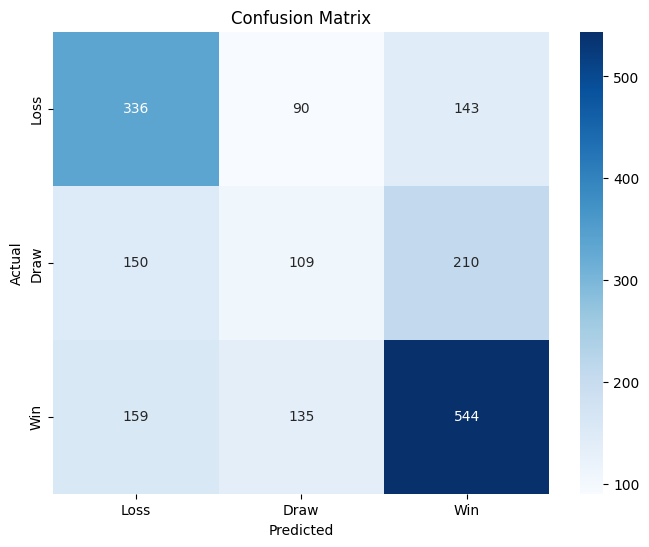

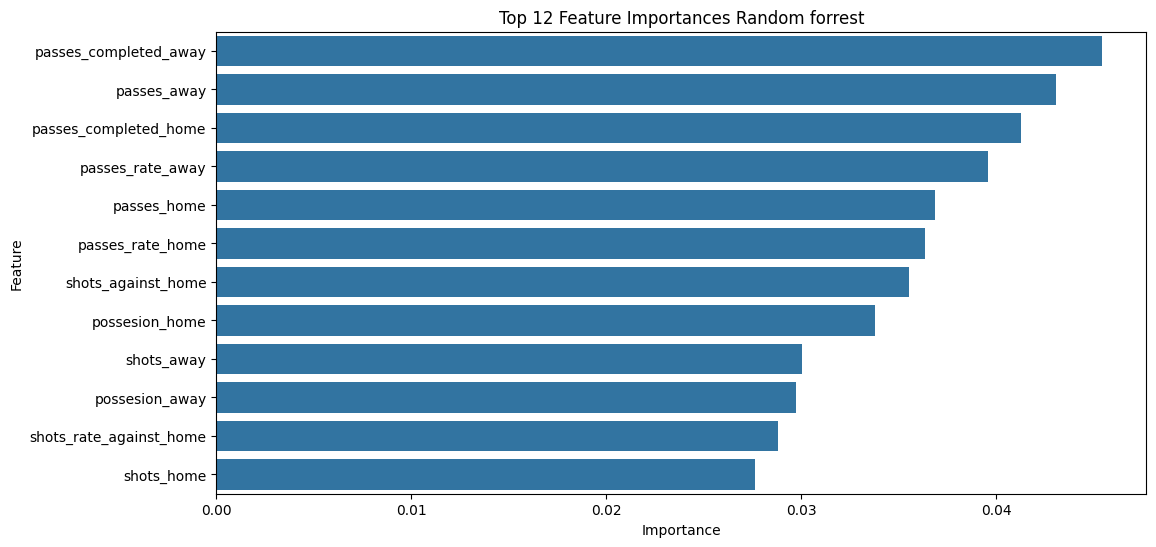

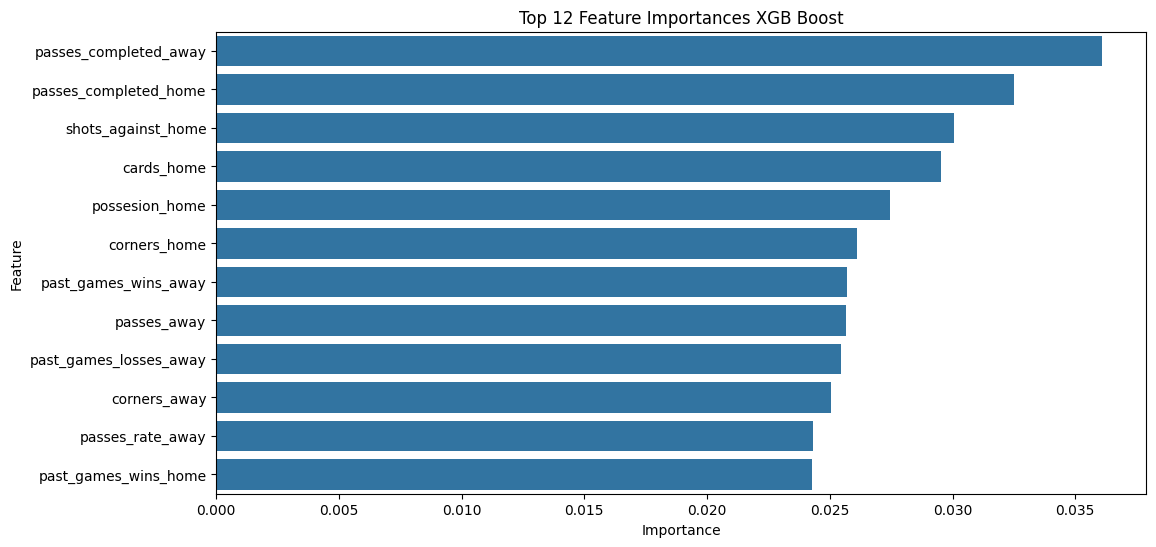

In [26]:
cm = confusion_matrix(y_test['target'], y_pred_rf)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Draw', 'Win'], yticklabels=['Loss', 'Draw', 'Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

importances = [rf_model.feature_importances_, xgb_model.feature_importances_]
name = ["Random forrest", "XGB Boost"]
step = 0
feature_names = feature_columns

for elem in importances:
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': elem
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(12))
    plt.title('Top 12 Feature Importances ' + name[step])
    plt.show()
    step += 1

## NN

In [18]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(final_df['target']),
                                     y=final_df['target'])

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

def build_model(hp):
    model = Sequential()

    # Define the input shape explicitly using the Input layer
    model.add(Input(shape=(X_train.shape[1],)))
    
    # First hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=384, step=32),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Second hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=256, step=16),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer for 3-class classification
    model.add(Dense(3, activation='softmax'))
    
    # Tune learning rate for the Adam optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create a Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=40,
    factor=3,
    directory='my_dir',  # Directory to store tuning results
    project_name='4_games_custom'
)

# Early stopping callback to avoid overtraining
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(X_train, kutils.to_categorical(y_train['target']), epochs=50, validation_split=0.15, callbacks=[stop_early], class_weight = class_weight_dict)

# Retrieve the best model found during the search
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Trial 90 Complete [00h 00m 27s]
val_accuracy: 0.4948657155036926

Best val_accuracy So Far: 0.5209320783615112
Total elapsed time: 00h 20m 00s
Best Hyperparameters:
{'units_1': 480, 'dropout_1': 0.2, 'units_2': 320, 'dropout_2': 0.1, 'units_3': 48, 'dropout_3': 0.30000000000000004, 'lr': 0.009050414058038053, 'tuner/epochs': 14, 'tuner/initial_epoch': 5, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0035'}


In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train['target']), y=y_train['target'])
# class_weights = compute_class_weight(class_weight='balanced',
#                                      classes=np.unique(final_df['target']),
#                                      y=final_df['target'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

num_classes = len(np.unique(y_train['target']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], num_classes)
y_test_encoded = keras.utils.to_categorical(y_test['target'], num_classes)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    BatchNormalization(),
    Dropout(0.3),  # Regularization

    Dense(128, activation='relu'),  # Hidden layer 1
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),  # Hidden layer 2
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

model.compile(
    optimizer=Adam(learning_rate=0.005),  # Adam optimizer with learning rate
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_encoded,
    validation_split=0.1,
    epochs=50,  # Start with 50 epochs, can tune later
    batch_size=64,  # Can be adjusted based on performance
    class_weight=class_weight_dict,  # Handling class imbalance
    verbose=0
)

test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
# validate_with_odds(X_test, y_test)

## Helper functions

In [17]:
def validate_with_odds(model, X_test, y_test, min_score = [0.5, 0.4, 0.5], min_odd = [0, 0, 0], logging=True):
    total = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    correct = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    
    odds = {
        "A": 0,
        "D": 0,
        "H": 0
    }

    probabilities = model.predict(X_test, verbose=0)
    prediction = np.argmax(probabilities, axis=1)
    target = np.array(y_test['target'])
    odd_away = np.array(y_test['odds.B365A'])
    odd_draw = np.array(y_test['odds.B365D'])
    odd_home = np.array(y_test['odds.B365H'])

    mask_away_total = (prediction[:] == 0) & (probabilities[:, 0] >= min_score[0])
    mask_away_corect = (prediction[:] == 0) & (target == 0) & (probabilities[:, 0] >= min_score[0])
    if min_odd[0] != 0:
        mask_away_total = mask_away_total & (odd_away[:] >= min_odd[0])
        mask_away_corect = mask_away_corect & (probabilities[:, 0] >= min_score[0])
    correct['A'] = np.sum(mask_away_corect)
    total['A'] = np.sum(mask_away_total)
    odds['A'] = np.sum(odd_away[mask_away_corect])

    mask_draw_total = (prediction[:] == 1) & (probabilities[:, 1] >= min_score[1])
    mask_draw_corect = (prediction[:] == 1) & (target == 1) & (probabilities[:, 1] >= min_score[1])
    if min_odd[1] != 0:
        mask_draw_total = mask_draw_total & (odd_draw[:] >= min_odd[1])
        mask_draw_corect = mask_draw_corect & (odd_draw[:] >= min_odd[1])
    correct['D'] = np.sum(mask_draw_corect)
    total['D'] = np.sum(mask_draw_total)
    odds['D'] = np.sum(odd_draw[mask_draw_corect])

    mask_home_total = (prediction[:] == 2) & (probabilities[:, 2] >= min_score[2])
    mask_home_corect = (prediction[:] == 2) & (target == 2) & (probabilities[:, 2] >= min_score[2])
    if min_odd[2] != 0:
        mask_home_total = mask_home_total & (odd_home[:] >= min_odd[2])
        mask_home_corect = mask_home_corect & (odd_home[:] >= min_odd[2])
    correct['H'] = np.sum(mask_home_corect)
    total['H'] = np.sum(mask_home_total)
    odds['H'] = np.sum(odd_home[mask_home_corect])
    
    final_win = 0
    final_total = 0
    if logging:
        for key in odds.keys():
            print("-------------------")
            print("Total count:", total[key])
            print("Correct count:", correct[key])
            if (total[key] == 0):
                continue
            print("Prediction %:", correct[key] / total[key])
            print("Total odd won: ", odds[key] - total[key])
            print("Expected win per game: ", (odds[key] - total[key]) / total[key])
            final_win += odds[key] - total[key]
            final_total += total[key]
        print("----------FINAL---------")
        print("Total odd won: ", final_win)
        print("Expected win per game: ", final_win / final_total )
        print("Percentage of games: ", final_total / len(y_test))

    return {
        "total": total,
        "correct": correct,
        "odds": odds,
        "final_win": final_win,
        "final_total": final_total
    }

In [43]:
def create_charts_by_type(probabilities, predictions, target, odds, game_type, min_prob=0.35, max_prob=0.8, step=0.01):
    prob_ranges = np.arange(min_prob, max_prob + step, step)

    graph_name = ""
    if game_type == 0:
        graph_name = "Away"
    elif game_type == 1:
        graph_name = "Draw"
    else:
        graph_name = "Home"
        
    total_odds = []
    mean_odds = []
    win_probs = []
    games_count = []
    probability = []
    
    for prob in prob_ranges[:-1]:
        mask = (probabilities[:, game_type] >= prob) & (y_pred[:] == game_type)
        games_in_range = np.sum(mask)
    
        if games_in_range > 10:
            wins_in_range = np.sum((predictions[mask] == game_type) & (predictions[mask] == target[mask]))
            odd_mask = (predictions[:] == game_type) & (target[:] == game_type) & mask
            total_odd_win = np.sum(odds[odd_mask]) - games_in_range
            mean_odd = np.mean(odds[odd_mask])
            win_prob = wins_in_range / games_in_range
    
            total_odds.append(total_odd_win)
            mean_odds.append(mean_odd)
            win_probs.append(win_prob)
            probability.append(prob)
            games_count.append(games_in_range)
    
    fig, axs = plt.subplots(2, 2, figsize=(18, 9))
    ax1 = axs[0,0]
    ax2 = axs[0,1]
    ax3 = axs[1,0]
    ax4 = axs[1,1]
    
    scatter1 = ax1.scatter(probability, total_odds, c=games_count, cmap='viridis', s=100)
    ax1.set_xlabel('Probability')
    ax1.set_ylabel('Total Odd Win')
    ax1.set_title(f'{graph_name}: Probability vs Total Odd Win')
    ax1.grid(True, alpha=0.3)
    fig.colorbar(scatter1, ax=ax1, label='Number of Games')
    for i, (x, y, count) in enumerate(zip(probability, total_odds, games_count)):
        ax1.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    scatter2 = ax2.scatter(probability, mean_odds, c=games_count, cmap='viridis', s=100)
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Mean Odd')
    ax2.set_title(f'{graph_name}: Win Probability vs Mean Odd')
    ax2.grid(True, alpha=0.3)
    fig.colorbar(scatter2, ax=ax2, label='Number of Games')
    for i, (x, y, count) in enumerate(zip(probability, mean_odds, games_count)):
        ax2.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

    scatter3 = ax3.scatter(win_probs, total_odds, c=games_count, cmap='viridis', s=100)
    ax3.set_xlabel('Win Probability')
    ax3.set_ylabel('Total Odd Win')
    ax3.set_title(f'{graph_name}: Win Probability vs Total Odd Win')
    ax3.grid(True, alpha=0.3)
    fig.colorbar(scatter3, ax=ax3, label='Number of Games')
    for i, (x, y, count) in enumerate(zip(win_probs, total_odds, games_count)):
        ax3.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    scatter4 = ax4.scatter(probability, win_probs, c=games_count, cmap='viridis', s=100)
    ax4.set_xlabel('Probability')
    ax4.set_ylabel('Win Probability')
    ax4.set_title(f'{graph_name}: Win Probability vs Mean Odd')
    ax4.grid(True, alpha=0.3)
    fig.colorbar(scatter4, ax=ax4, label='Number of Games')
    for i, (x, y, count) in enumerate(zip(probability, win_probs, games_count)):
        ax4.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()

## TESTING

In [18]:
print("Loss: " + str(len(y_test.loc[y_test['target'] == 0])))
print("Draw: " + str(len(y_test.loc[y_test['target'] == 1])))
print("Win: " + str(len(y_test.loc[y_test['target'] == 2])))

print("Loss: " + str(len(y_test_validation.loc[y_test_validation['target'] == 0])))
print("Draw: " + str(len(y_test_validation.loc[y_test_validation['target'] == 1])))
print("Win: " + str(len(y_test_validation.loc[y_test_validation['target'] == 2])))

Loss: 569
Draw: 469
Win: 838
Loss: 682
Draw: 523
Win: 896


Loss: 580
Draw: 472
Win: 823
Loss: 682
Draw: 523
Win: 896

In [19]:
values = np.arange(0.35, 0.63 + 0.05, 0.02)
intervals = np.array([[x, x, x] for x in values])

models = tuner.get_best_models(num_models=50)
step = 0 
final_version = {}
for model in models:
    maxim_testing = {
        "A": 0,
        "D": 0,
        "H": 0,
    }
    maxim_validation = {
        "A": 0,
        "D": 0,
        "H": 0,
    }
    best_version = {
        "A": 0,
        "D": 0,
        "H": 0,
    }
    for interval in intervals:
        testing = validate_with_odds(model, X_test, y_test, interval, logging=False)
        validation = validate_with_odds(model, X_test_validation, y_test_validation, interval, logging=False)

        if maxim_testing['A'] == 0: 
            maxim_testing['A'] = {
                "step": 0.35,
                "value": testing['odds']['A'] - testing['total']['A'] - 100
            }
            maxim_testing['D'] = {
                "step": 0.35,
                "value": testing['odds']['D'] - testing['total']['D'] - 100
            }
            maxim_testing['H'] = {
                "step": 0.35,
                "value": testing['odds']['H'] - testing['total']['H'] - 100
            }
            maxim_validation['A'] = {
                "step": 0.35,
                "value": validation['odds']['A'] - validation['total']['A'] - 100
            }
            maxim_validation['D'] = {
                "step": 0.35,
                "value": validation['odds']['D'] - validation['total']['D'] - 100
            }
            maxim_validation['H'] = {
                "step": 0.35,
                "value": validation['odds']['H'] - validation['total']['H'] - 100
            }
            best_version['A'] = {
                "step": 0.35,
                "value": validation['odds']['A'] - validation['total']['A'] + testing['odds']['A'] - testing['total']['A'] - 100
            }
            best_version['D'] = {
                "step": 0.35,
                "value": validation['odds']['D'] - validation['total']['D'] + testing['odds']['D'] - testing['total']['D'] - 100
            }
            best_version['H'] = {
                "step": 0.35,
                "value": validation['odds']['H'] - validation['total']['H'] + testing['odds']['H'] - testing['total']['H'] - 100
            }
            continue

        for type_of_game, limit, index in [['A', 100, 0], ['D', 25, 1], ['H', 125, 2]]:
            if (maxim_testing[type_of_game]['value'] < testing['odds'][type_of_game] - testing['total'][type_of_game]) and testing['total'][type_of_game] > limit:
                 maxim_testing[type_of_game] = {
                    "step": interval[index],
                    "value": testing['odds'][type_of_game] - testing['total'][type_of_game]
                }
            if (maxim_validation[type_of_game]['value'] < validation['odds'][type_of_game] - validation['total'][type_of_game]) and validation['total'][type_of_game] > limit:
                 maxim_validation[type_of_game] = {
                    "step": interval[index],
                    "value": validation['odds'][type_of_game] - validation['total'][type_of_game]
                }

            if ((best_version[type_of_game]['value'] < validation['odds'][type_of_game] - validation['total'][type_of_game] + testing['odds'][type_of_game] - testing['total'][type_of_game])
            and validation['total'][type_of_game] > limit and testing['total'][type_of_game] > limit 
            and validation['odds'][type_of_game] - validation['total'][type_of_game] > 0 and testing['odds'][type_of_game] - testing['total'][type_of_game] > 0):
                 best_version[type_of_game] = {
                    "step": interval[index],
                    "value": validation['odds'][type_of_game] - validation['total'][type_of_game] + testing['odds'][type_of_game] - testing['total'][type_of_game],
                    "testing": testing['odds'][type_of_game] - testing['total'][type_of_game],
                    "testing_total": testing['total'][type_of_game],
                    "validation": validation['odds'][type_of_game] - validation['total'][type_of_game],
                    "validation_total": validation['total'][type_of_game]
                 }

    final_version[step] = best_version
    step += 1

In [19]:
model = load_model("D:\\Repos\\Personal\\score-lab-ai\\checkpoints\\model_nr_18_clasic.keras")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
interval = [0.45, 0.37, 0.47]
print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], 3)
y_test_encoded = keras.utils.to_categorical(y_test['target'], 3)
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
validate_with_odds(model, X_test, y_test, interval)
validate_with_odds(model, X_test_validation, y_test_validation, interval)

C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

        Loss       0.49      0.64      0.56       569
        Draw       0.31      0.17      0.22       469
         Win       0.60      0.62      0.61       838

    accuracy                           0.51      1876
   macro avg       0.46      0.48      0.46      1876
weighted avg       0.49      0.51      0.50      1876

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.5211 - loss: 1.0024 
-------------------
Total count: 423
Correct count: 243
Prediction %: 0.574468085106383
Total odd won:  30.379999999999995
Expected win per game:  0.07182033096926713
-------------------
Total count: 174
Correct count: 55
Prediction %: 0.3160919540229885
Total odd won:  23.159999999999968
Expected win per game:  0.13310344827586187
-------------------
Total count: 390
Correct count: 283
Prediction %: 0.7256410256410256
Total odd won:  2.490000000000009
Expected win per game:  0.006384615384615408
--

{'total': {'A': 512, 'D': 190, 'H': 386},
 'correct': {'A': 285, 'D': 64, 'H': 281},
 'odds': {'A': 532.95, 'D': 231.98000000000002, 'H': 402.51},
 'final_win': 79.44000000000005,
 'final_total': 1088}

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\ghera\AppData\Local\Temp\ipykernel_7432\149480944.py:1: SyntaxWarning: invalid escape sequence '\R'
  probabilities = load_model("D:\Repos\Personal\score-lab-ai\checkpoints\model_nr_18_clasic.keras").predict(X_test)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


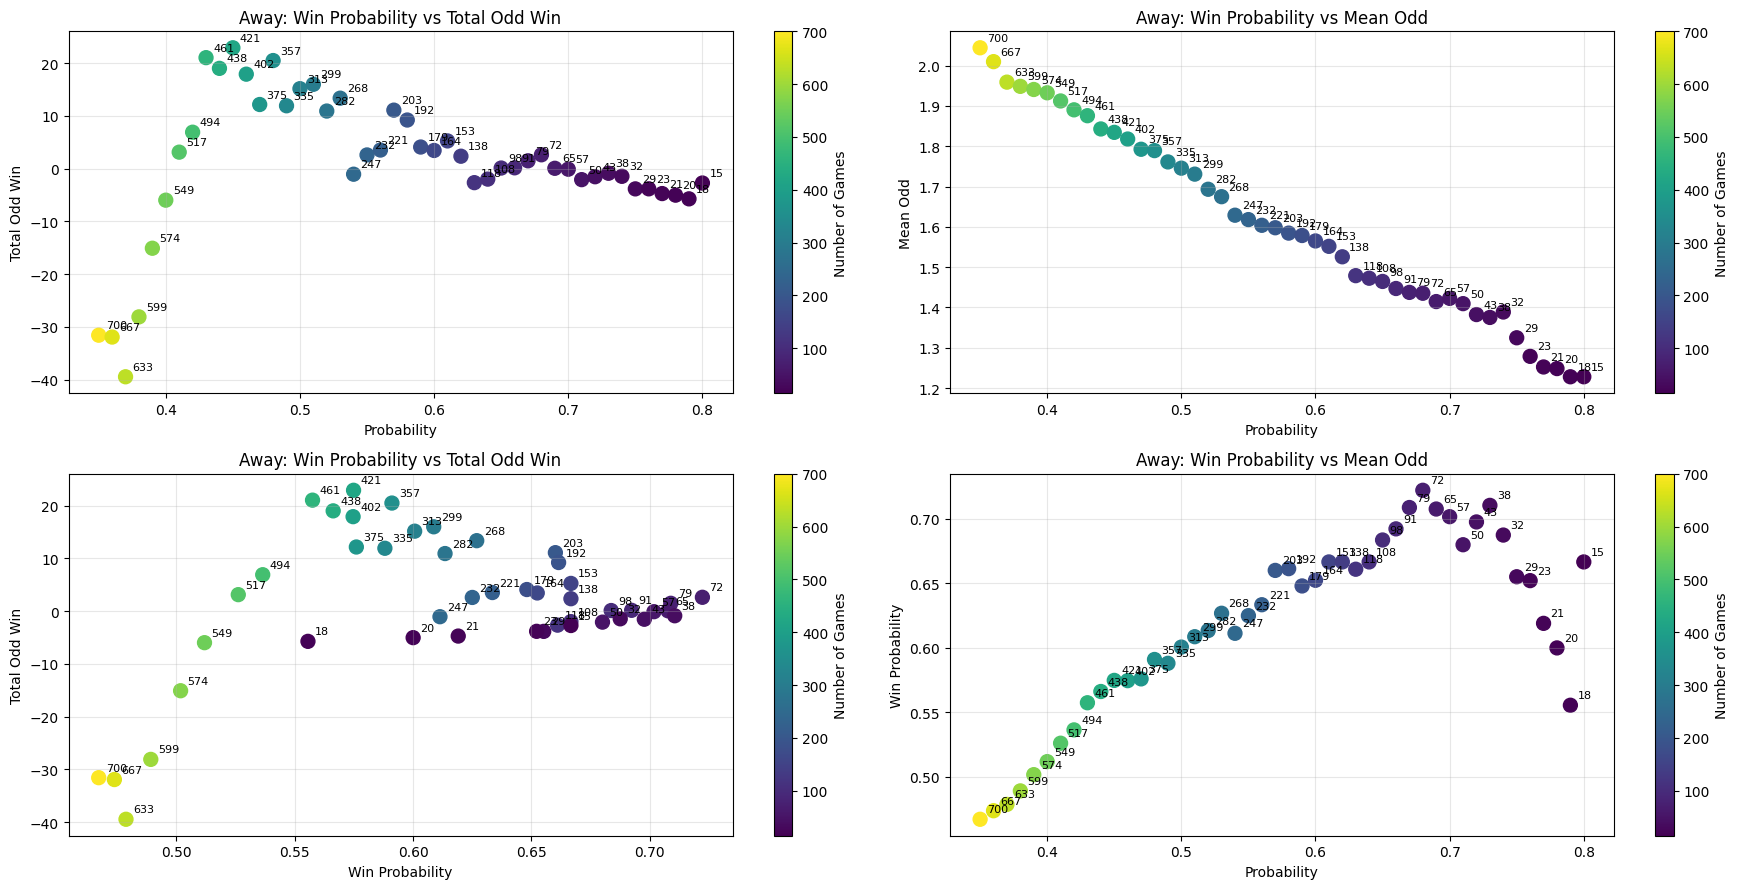

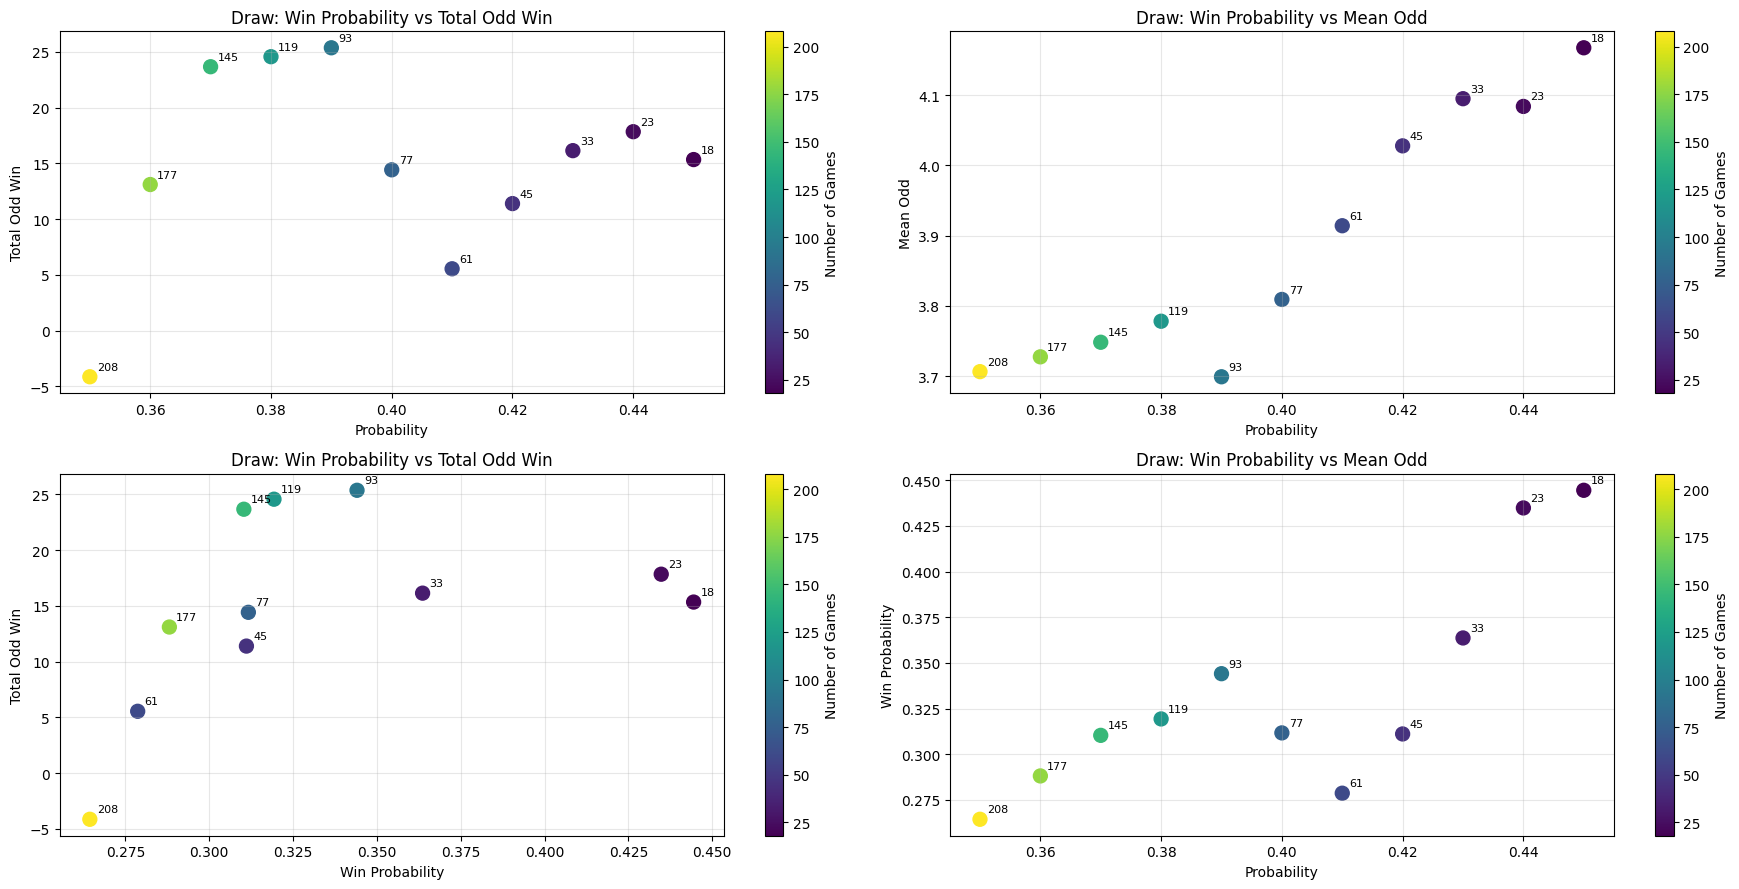

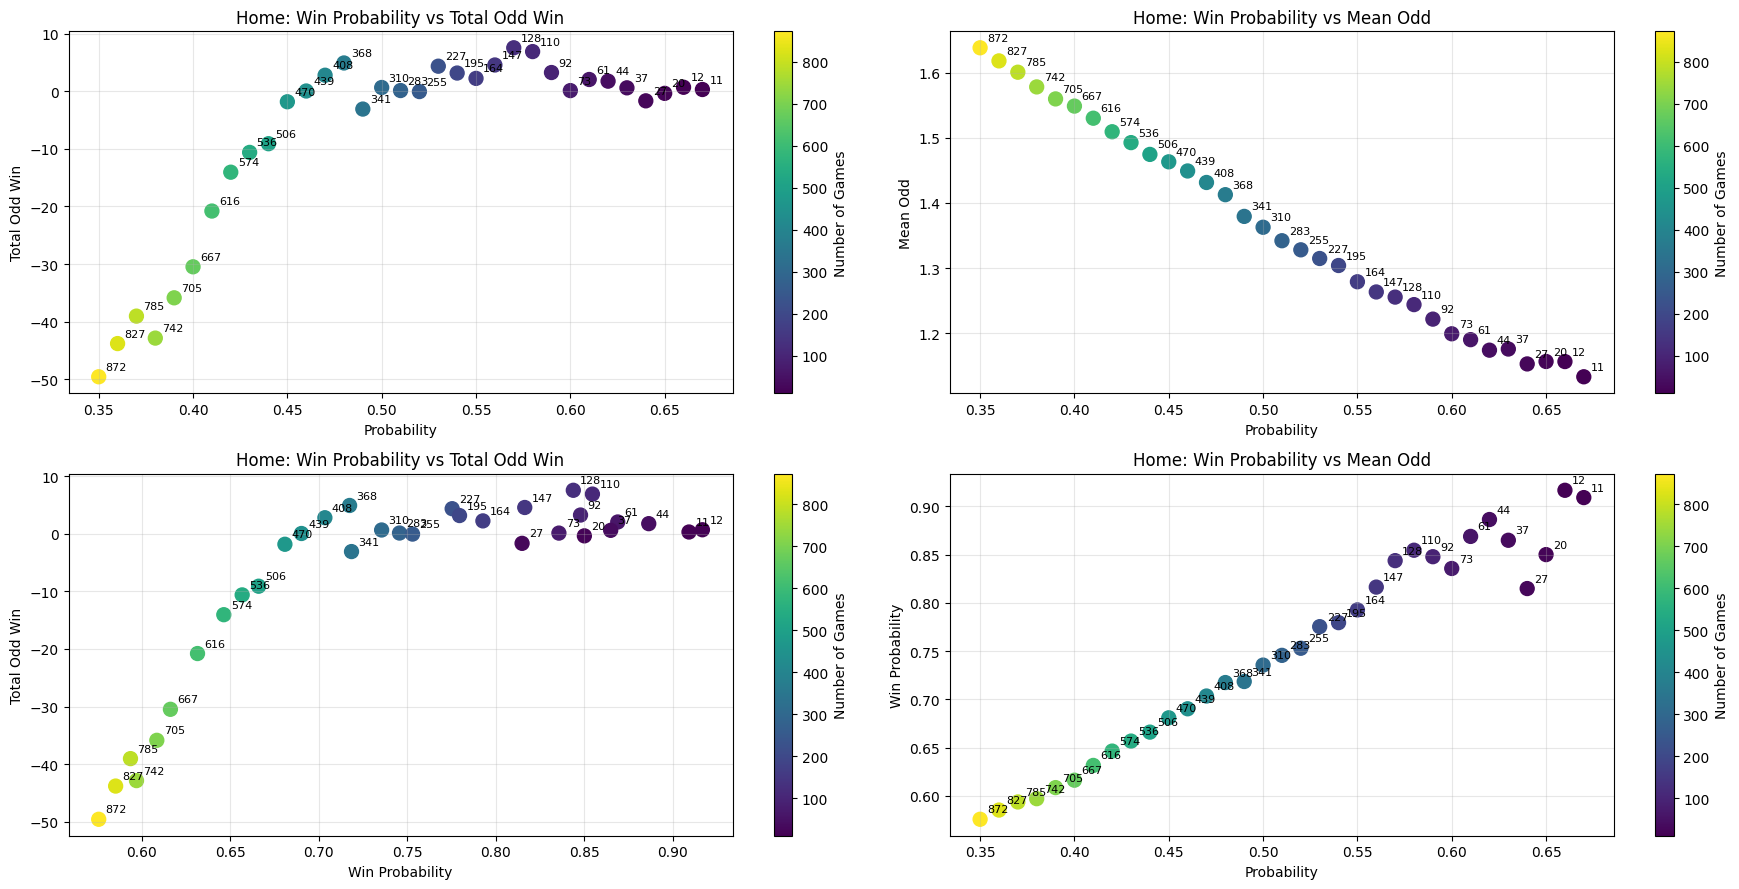

In [44]:
probabilities = load_model("D:\Repos\Personal\score-lab-ai\checkpoints\model_nr_18_clasic.keras").predict(X_test)
predictions = np.argmax(probabilities, axis=1)
create_charts_by_type(probabilities, predictions, np.array(y_test['target']), np.array(y_test['odds.B365A']), 0)
create_charts_by_type(probabilities, predictions, np.array(y_test['target']), np.array(y_test['odds.B365D']), 1)
create_charts_by_type(probabilities, predictions, np.array(y_test['target']), np.array(y_test['odds.B365H']), 2)

## Saving

In [27]:
joblib.dump(scaler, 'checkpoints/saved_scaler_model_nr_41_5_games.pkl')

['checkpoints/saved_scaler_model_nr_41_5_games.pkl']